<h1 style="text-align: center;">Reconhecimento de Padrões - T2</h1>
<h2 style="text-align: center;">Erick Lima Trentini</h2>

# 1. Introdução

Neste trabalho iremos testar a acurácia de vários modelos de classificação, utilizando de um método de redução dos dados por prototipação, já que a quantidade de dados que temos é um pouco acima do comum.

Com isso é possível não só reduzir a quantidade de dados com que os modelos irão trabalhar, como é possível balancear o dataset criando protótipos apenas para as classes mais numerosas, ou utilizando o mesmo número de protótipos para cada classe.

In [3]:
from sklearn.cluster import MiniBatchKMeans
import datasets
import utils
import tester
import models
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import progressbar
%matplotlib inline

# 2. Dataset

Este dataset é um conjunto de clientes de cartão de crédito, onde os atributos são características do cliente e o label indica se o cliente é um bom pagador ou não.

Alguns dos atributos deste dataset são categóricos como gênero e escolaridade. Para vermos o impacto disso, foram testados alguns alguns modelos, comparando suas performances no dataset original e um processado com atributos criados para cada categoria dos atributos categóricos.

In [278]:
data = datasets.credit_cards(normalized=False)
Y = data.Y
X = data.X
newX = []
for x in X:
    gender = [0, 0]
    gender[int(x[1])-1] = 1
    education = [0, 0, 0, 0, 0, 0]
    education[int(x[2]) - 1] = 1
    marital = [0, 0, 0]
    marital[int(x[3]) - 1] = 1
    newX.append(list(x[0:3]) + marital + list(x[4:]))

processed_data = datasets.Dataset(newX, Y, normalized = True)

Com esse processamento, além de aumentar o número de atributos, os modelos performaram pior que o dataset original, logo o dataset original será utilizado neste trabalho.

Para os testes, como as matrizes de covariância são muito mal condicionadas, o melhor resultado foi obtido utilizando a matriz de covariância 'pooled'.

In [280]:
original_data = datasets.Dataset(data.X, data.Y, normalized=True)
t = tester.Tester(original_data, models.CQG(friedman_value=1))
t.test(n_tests=10)
stats = t.statistics()
stats.print_all()

100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.810083,0.809667,0.802,0.818333,0.006055,0.968826,0.255857


In [279]:
importlib.reload(utils)
t = tester.Tester(processed_data, models.CQG(friedman_value=1))
t.test(n_tests=10)
stats = t.statistics()
stats.print_all()

100% (10 of 10) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.792733,0.782,0.774667,0.813833,0.016198,0.989311,0.10356


## 2.1. Overview do dataset

O dataset possui 23 atributos e 30000 entradas, ou seja, é um dataset grande. Além disso os dados são mal distribuídos, tendo-se a maior concentração de dados na classe '0' como podemos ver a seguir.

(30000, 23)
{0: 23364, 1: 6636}


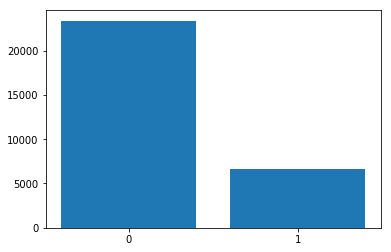

In [285]:
print(original_data.X.shape)
cd = utils.to_class_dict(original_data.X, original_data.Y)
c_sizes = {x:len(cd[x]) for x in sorted(cd)}
print(c_sizes)
plt.bar([0, 1], [c_sizes[0], c_sizes[1]])
plt.xticks([0, 1])
plt.show()

Aqui está uma representação desses dados com PCA para termos uma noção da distribuição deles no espaço:

(30000, 13)


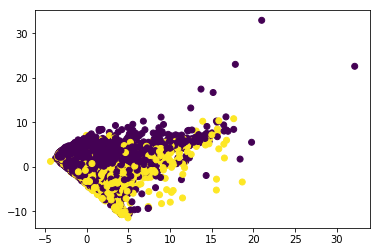

In [286]:
pca = utils.PCA()
pca.fit(original_data.X)
X_ = pca.transform(original_data.X, min_var=0.9)
print(X_.shape)
plt.scatter(X_[:, 0], X_[:, 1], c=original_data.Y)
plt.show()

# 3. Prototipação

Nesta seção iremos utilizar o algorítmo k-means para criarmos protótipos do dado original, onde cada representante do cluster irá substituir todo o cluster.

Para verificarmos que esta é uma boa prototipação, iremos utilizar o índice SSD (Sum of Squared Distances), que como o nome já diz, é a soma de todas as distâncias ao quadrado dos elementos dos clusters para seus representantes.

In [301]:
def calculateSSD(model, X):
    acc = 0
    for i, x in enumerate(X):
        label = model.labels_[i]
        z = x - model.cluster_centers_[label]
        acc += np.dot(z, z)

    return acc

Utilizaremos também o k-means para cada classe do dado original para que se possa prototipar as classes com a mesma quantidade de dados, balanceando assim o dataset.

In [ ]:
def createKmeans(data, n_clusters):
    model_list = [MiniBatchKMeans(n_clusters=n_clusters, init_size=n_clusters*3) for _ in data.cd]
    for y in data.cd:
        model_list[y].fit(data.cd[y])
        
    ssd = sum([calculateSSD(model_list[y], data.cd[y]) for y in data.cd])
    return model_list, ssd

E uma função para reconstruir o dataset a partir desses representantes.

In [303]:
def create_custom_dataset(model_list):
    X, Y = [], []
    for i, m in enumerate(model_list):
        X.extend(m.cluster_centers_)
        Y.extend([i] * len(m.cluster_centers_))

    return datasets.Dataset(np.array(X), np.array(Y), normalized=True)

## 3.1. Escolha do K

Para fazermos a prototipação, precisamos escolher um K que melhor represente os dados e que não seja perdida muita acurácia ao utilizar os modelos de previsão. 

Para isso, foram testados alguns modelos com k = {50, 100, 200, 500, 1000, 2000, 5000}

In [304]:
def create_list_of_custom_datasets(data):
    custom_datasets = []
    with progressbar.ProgressBar(max_value=7) as bar:
        for i, k in enumerate([50, 100, 200, 500, 1000, 2000, 5000]):
            bar.update(i)
            model_list = createKmeans(data, k)[0]
            custom_datasets.append(create_custom_dataset(model_list))
    return custom_datasets

def test_k_on_model(custom_datasets, model):
    accs = []
    for dataset in custom_datasets:
        t = tester.Tester(dataset, model)
        t.test()
        stats = t.statistics()
        accs.append(stats.acc_mean())
    return accs

In [305]:
custom_datasets = create_list_of_custom_datasets(data)

100% (7 of 7) |##########################| Elapsed Time: 0:01:49 Time:  0:01:49


#### Teste com KNN (k=3)

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
100% (100 of 100) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
100% (100 of 100) |######################| Elapsed Time: 0:01:09 Time:  0:01:09


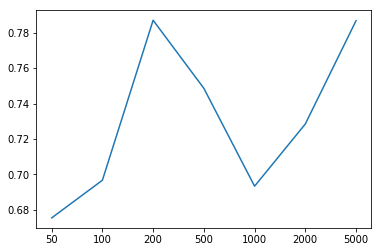

In [306]:
accs_knn = test_k_on_model(custom_datasets, models.KNN(3))
plt.plot(accs_knn)
plt.xticks(range(7), [50, 100, 200, 500, 1000, 2000, 5000])
plt.show()

#### Teste com CQG

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (100 of 100) |######################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (100 of 100) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (100 of 100) |######################| Elapsed Time: 0:00:09 Time:  0:00:09


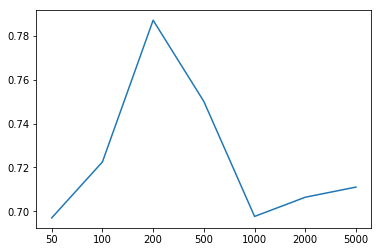

In [339]:
accs_cqg = test_k_on_model(custom_datasets, models.CQG(friedman_value=1))
plt.plot(accs_cqg)
plt.xticks(range(7), [50, 100, 200, 500, 1000, 2000, 5000])
plt.show()

#### Teste com DMC

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (100 of 100) |######################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (100 of 100) |######################| Elapsed Time: 0:00:04 Time:  0:00:04


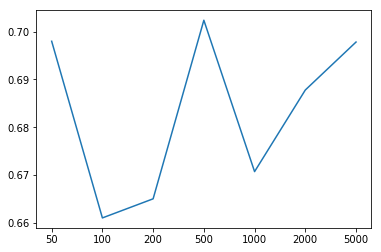

In [314]:
accs_dmc = test_k_on_model(custom_datasets, models.DMC())
plt.plot(accs_dmc)
plt.xticks(range(7), [50, 100, 200, 500, 1000, 2000, 5000])
plt.show()

Como podemos ver, em média quando utilizamos em torno de 200 protótipos para cada classe os modelos performam de forma desejável, apresentando um bom custo-benefício de redução dos dados.

Logo, nada mais justo que utilizar 200 protótipos para calcular as acurácias dos modelos.

# 4. Testando o Dataset Prototipado

Primeiro, iremos rodar o k-médias algumas vezes, buscando reduzir o índice SSD, que indicaria uma menor perda de informação por utilizar protótipos que estejam mais próximos dos dados que eles irão substituir.

In [340]:
min_model_list, min_ssd = None, np.inf
with progressbar.ProgressBar(max_value=20) as bar:
    for i in range(20):
        bar.update(i)
        model_list, ssd = createKmeans(data, 200)
        if ssd < min_ssd:
            min_model_list, min_ssd = model_list, ssd

100% (20 of 20) |########################| Elapsed Time: 0:00:27 Time:  0:00:27


Com ele, criamos o dataset a partir dos protótipos

In [341]:
reduced_data = create_custom_dataset(min_model_list)

Assim, podemos começar a testar.

## 4.1. Testes Sem Redução

In [320]:
all_statistics = {}

### 4.1.1. KNN (5)

In [321]:
m_tester = tester.Tester(original_data, models.KNN(k=5))
m_tester.test()
stats = m_tester.statistics()
all_statistics['knn_5'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:26:58 Time:  0:26:58


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.793338,0.793167,0.783,0.802667,0.004457,0.919025,0.349285


### 4.1.2. NN

In [322]:
m_tester = tester.Tester(original_data, models.KNN(k=1))
m_tester.test()
stats = m_tester.statistics()
all_statistics['nn'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:22:41 Time:  0:22:41


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.727728,0.728333,0.716667,0.741667,0.005105,0.825176,0.38592


### 4.1.3. DMC

In [323]:
m_tester = tester.Tester(original_data, models.DMC())
m_tester.test()
stats = m_tester.statistics()
all_statistics['dmc'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:21 Time:  0:00:21


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.658243,0.658583,0.643333,0.6765,0.006195,0.665725,0.631877


### 4.1.4. CQG

In [352]:
m_tester = tester.Tester(original_data, models.CQG(friedman_value=1))
m_tester.test()
stats = m_tester.statistics()
all_statistics['cqg'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:25 Time:  0:00:25


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.811655,0.811333,0.8015,0.821,0.004851,0.969156,0.257077


### 4.1.5. Gaussian NB

In [326]:
m_tester = tester.Tester(original_data, models.CQG(naive=True))
m_tester.test()
stats = m_tester.statistics()
all_statistics['gnb'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:27 Time:  0:00:27


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.701255,0.714583,0.558333,0.7695,0.046462,0.714384,0.655134


## 4.2. Test With the Reduced Dataset

### 4.2.1. KNN (5)

In [342]:
m_tester = tester.Tester(reduced_data, models.KNN(k=3))
m_tester.test()
stats = m_tester.statistics()
all_statistics['knn_5_red'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.77025,0.775,0.6375,0.8625,0.046361,0.965844,0.573577


### 4.2.2. NN

In [343]:
m_tester = tester.Tester(reduced_data, models.KNN(k=1))
m_tester.test()
stats = m_tester.statistics()
all_statistics['nn_red'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.78575,0.7875,0.6875,0.875,0.047237,0.936165,0.640364


### 4.2.3. DMC

In [344]:
m_tester = tester.Tester(reduced_data, models.DMC())
m_tester.test()
stats = m_tester.statistics()
all_statistics['dmc_red'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.641,0.64375,0.5375,0.7375,0.04684,0.627063,0.654519


### 4.2.4. CQG
Neste caso, utilizar o parâmetro da regularização de friedman como 0 gerou o melhor resultado.

In [350]:
m_tester = tester.Tester(reduced_data, models.CQG(friedman_value=0))
m_tester.test()
stats = m_tester.statistics()
all_statistics['cqg_red'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.8715,0.875,0.7875,0.9625,0.039334,0.853095,0.890118


### 4.2.5. Gaussian NB

In [346]:
m_tester = tester.Tester(reduced_data, models.CQG(naive=True))
m_tester.test()
stats = m_tester.statistics()
all_statistics['gnb_red'] = stats.get_values()
stats.print_all()

100% (100 of 100) |######################| Elapsed Time: 0:00:00 Time:  0:00:00


Test Accuracy:


Mean,Median,Min,Max,STD,Specificity,Sensibility
0.833875,0.8375,0.6875,0.95,0.051213,0.827569,0.840241


## 4.3. Todos os Resultados

In [1]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option("display.precision", 2)

keys = ['knn_5', 'nn', 'dmc', 'cqg', 'gnb', 'knn_5_red', 'nn_red', 'dmc_red', 'cqg_red', 'gnb_red']
ordered_stats = {k: all_statistics[k] for k in keys}

cols = ['Mean', 'Median', 'Min', 'Max', 'STD', 'Specificity', 'Sensibility']

df = pd.DataFrame.from_dict(ordered_stats, orient='index', columns=cols)

th_props = [('font-size', '14px'),('text-align', 'center'),
            ('font-weight', 'bold'),('color', '#6d6d6d'),('background-color', '#DDD')]

# Set CSS properties for td elements in dataframe
td_props = [('font-size', '14px'),('text-align', 'center')]

# Set table styles
styles = [dict(selector="th", props=th_props), dict(selector="td", props=td_props)]

df.style.format({k:"{:.1%}" for k in cols if k != 'STD'}).set_table_styles(styles)

NameError: name 'all_statistics' is not defined

# 5. Conclusão

Podemos ver que a técnica de redução do dataset por prototipação, não só acelera o treinamento e predição dos modelos em ordens de magnitude, quanto podem até melhorar a acurácia desses modelos, provavelmente por diminuir a quantidade de outliers e reduzir o viés causado pelo conjunto de treino, além do balanceamento das classes que pode ter um grande impacto no treinamento do modelo.

Link do github: https://github.com/ericklt/pattern-recognition